In [4]:
import pandas as pd
import numpy as np
import itertools
import sklearn
from sklearn import datasets, linear_model, model_selection, metrics
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
n = 50000

In [7]:
counts_df = pd.read_csv("/Users/Sundipta/Desktop/PCR Data/dataFrame_170530_merged_F16.csv")
counts_df.head()

,index,PayloadID,Count_enrich,Count_ePCR10,Count_pcrb
0,0,0,110,57,32.0
1,1,1,76,19,7.0
2,2,2,185,73,30.0
3,3,3,102,40,16.0
4,4,4,163,79,19.0


In [8]:
# Sort by PayloadID, as this is how the feature vector will be sorted
counts_df = counts_df.sort_values(by='PayloadID')

In [9]:
counts_df = counts_df.iloc[:n]

In [12]:
counts_df['ePCR_target'] = counts_df["Count_ePCR10"] / counts_df["Count_enrich"]
counts_df['PCR_target'] = counts_df["Count_pcrb"] / counts_df["Count_enrich"]
counts_df.head()

,index,PayloadID,Count_enrich,Count_ePCR10,Count_pcrb,ePCR_target,PCR_target
0,0,0,110,57,32.0,0.518182,0.290909
1,1,1,76,19,7.0,0.250000,0.092105
2,2,2,185,73,30.0,0.394595,0.162162
3,3,3,102,40,16.0,0.392157,0.156863
4,4,4,163,79,19.0,0.484663,0.116564


In [13]:
raw_seqs = pd.read_csv("/Users/Sundipta/Desktop/PCR Data/seq_ID16.txt", sep=",", names=["Seq"])
# Restrict to sequences that have counts
sequences = raw_seqs.iloc[:, 0].str.slice(3,-3).iloc[counts_df['PayloadID']]
sequences.head()

0    AACATCGTGTCCAAGCAAGTAGCTAGCTAGCTAGTCACTCGAGCGT...
1    AACATCGTGTCCAAGCAAGTGCTAGCTAGCTAGCACTCTCGCTGAG...
2    AACATCGTGTCCAAGCAAGTCTAGCTAGCTAGCATCGTCGCAGTAC...
3    AACATCGTGTCCAAGCAAGTTAGCTAGCTAGCTGCAGTGCACATCA...
4    AACATCGTGTCCAAGCAAGTAGTCAGCTAGCTAGTCGAGAGCGCAT...
Name: Seq, dtype: object

In [48]:
def k_mers(sequence):
    k = 3
    counts = {}
    xs = ["".join(x) for x in itertools.product("ATGC", repeat=k)]
    for x in xs:
        counts[x] = 0
        
    for i in range(20,50):
        kmer = sequence[i: i+k]
        # Increment the count for this kmer
        counts[kmer] += 1
        
    #for i in range(-50,-20):
     #   kmer = sequence[i: i+k]
        # Increment the count for this kmer
      #  counts[kmer] += 1
    return counts

In [49]:
X = pd.DataFrame(list(sequences.apply(k_mers)))
Y = counts_df["ePCR_target"]
X.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0,0,0,0,0,0,1,1,0,4,...,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,2,1,3,...,1,2,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,3,...,2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,5,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,3,...,1,0,0,0,0,0,0,0,0,0


In [50]:
regr = linear_model.Ridge()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y)
regr.fit(X_train, y_train)

# The mean squared error
error = np.mean((regr.predict(X_test) - y_test) ** 2)
print "Mean squared error:", error.mean()
# Explained variance score: 1 is perfect prediction
print 'Variance score: %.5f' % regr.score(X_test, y_test)

Mean squared error: 0.00508436961793
Variance score: 0.00984


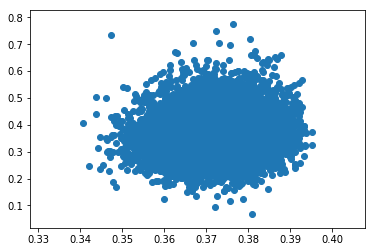

In [51]:
plt.scatter(regr.predict(X_test), y_test);

In [52]:
for x in [0.1, 0.5, 1, 10, 100, 1000]:
    regr = linear_model.Ridge(alpha=x)
    regr.fit(X_train, y_train)
    # Explained variance score: 1 is perfect prediction
    scores = model_selection.cross_val_score(regr, X_train, y_train, cv=5)
    predicted = model_selection.cross_val_predict(regr, X_test, y_test, cv=5)
    errors = np.mean((predicted - y_test) **2)
    print(x, regr.score(X_test, y_test), errors.mean())

(0.1, 0.0098383541180823153, 0.0050984366030216999)
(0.5, 0.0098390490230845229, 0.0050984160400212074)
(1, 0.0098399149989524259, 0.0050983905595049055)
(10, 0.0098550082770814118, 0.0050979713299368502)
(100, 0.009963384768343797, 0.0050961044377993252)
(1000, 0.0097996121904848632, 0.0050988051829233072)


In [53]:
def gc_content(sequence):
    return (sequence.count('G') + sequence.count('C')) / len(sequence)

gc_content("GTCTCG")

0.6666666666666666

In [54]:
X['gc'] = list(sequences.apply(gc_content))
X.head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,gc
0,0,0,0,0,0,0,1,1,0,4,...,0,0,1,0,0,0,0,0,0,0.480000
1,0,0,0,0,0,0,0,2,1,3,...,2,1,0,0,0,0,0,0,0,0.520000
2,0,0,0,0,1,0,0,1,0,3,...,0,0,0,0,1,0,0,0,0,0.493333
3,0,0,0,0,1,0,0,0,0,5,...,0,0,2,0,0,0,0,0,0,0.473333
4,0,0,0,0,1,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0.493333


In [56]:
regr = linear_model.Ridge()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y)
regr.fit(X_train, y_train)

# The mean squared error
error = np.mean((regr.predict(X_test) - y_test) ** 2)
print("Mean squared error:", error)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.5f' % regr.score(X_test, y_test))

('Mean squared error:', 0.0049877213507756191)
Variance score: 0.03435


* Subset data to have more 'interesting' cases, prevent negative examples from drowning out the rest.
* Other features:
  * GC content
  * Focus on first/last 20 bases
* Other targets:
  * normal / emulsion ratio

In [ ]:
X.sum()

In [ ]:
import coral as cr

In [ ]:
cr_seq = sequences.apply(cr.ssDNA)

In [ ]:
X['tm_start'] = list(cr_seq.apply(lambda x: x[20:50].tm()))
X['tm_end'] = list(cr_seq.apply(lambda x: x[-50:-20].tm()))

X.head()

In [ ]:
#vienna = cr.structure.ViennaRNA()
#cr_seq.iloc[:100].apply(lambda x: vienna.fold(x[20:50])['mfe'])

In [ ]:
for x in [0.1, 0.5, 1, 10, 100, 1000]:
    regr = linear_model.Ridge(alpha=x)
    regr.fit(X, Y)
    # Explained variance score: 1 is perfect prediction
    print(x, regr.score(X, Y))

In [ ]:
(X.sum() != 0).sum() / X.shape[1]